# XAI Laboratory 01 - Tabular Methods

For this practice, you will need the following dataset:

- **fifa**: regression dataset containing FIFA players data:
    - short_name: name of the player
    - nationality
    - overall: overall score of the player (potential output)
    - potential: potential score of the player (potential output)
    - wage_eur: contract cancellation fine of the player (potential output)
    - value_eur: value in euros of the player (potential output)
    - age: age of the player in years
    - height_cm: height of the player in cm
    - weight_kg: weight of the player in kg
    - attacking_skills: several variables related to attacking
    - defending_skills: several variables related to defending
    - goalkeeping_skills: several variables related to goalkeeping

Use what you have learned from the `tabular_explanation.ipynb` notebook to complete the questions.

In [27]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# XAI
import shap
import lime
from alepython import ale_plot # You might need to install from source: pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

np.random.seed(2025)

In [28]:
### Load file --------------------------------------------
import os
print(os.getcwd())
try:
    df = pd.read_csv('data/fifa.csv')
except:
    df = pd.read_csv('../data/fifa.csv')
    
df.head()

c:\Users\anton\OneDrive\Escritorio\MASTER\Etica_IA\Explicabilidad\p1-tabular-methods-AntonioLDM17


,short_name,nationality,overall,potential,wage_eur,value_eur,age,height_cm,weight_kg,attacking_crossing,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,L. Messi,Argentina,94,94,565000,95500000,32,170,72,88,...,75,96,33,37,26,6,11,15,14,8
1,Cristiano Ronaldo,Portugal,93,93,405000,58500000,34,187,83,84,...,85,95,28,32,24,7,11,15,14,11
2,Neymar Jr,Brazil,92,92,290000,105500000,27,175,68,87,...,90,94,27,26,29,9,9,15,15,11
3,J. Oblak,Slovenia,91,93,125000,77500000,26,188,87,13,...,11,68,27,12,18,87,92,78,90,89
4,E. Hazard,Belgium,91,91,470000,90000000,28,175,74,81,...,88,91,34,27,22,11,12,6,8,8


In [29]:
X = df.drop(["short_name", "nationality", "overall", "potential", "value_eur", "wage_eur"], axis = 1)
y = df['value_eur']

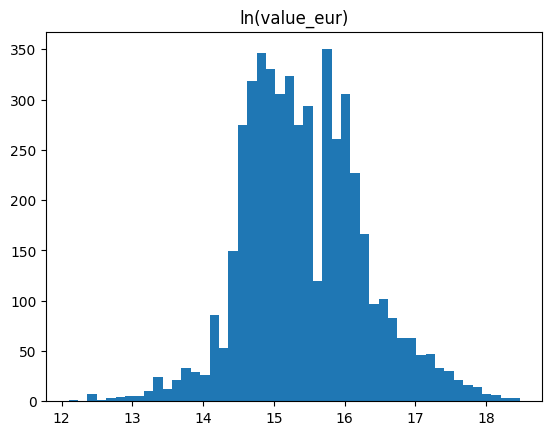

In [30]:
# Change scale of output variable
ylog = np.log(y)

plt.hist(ylog, bins='auto')
plt.title("ln(value_eur)")
plt.show()

In [31]:
X_train, X_test, ylog_train, ylog_test, y_train, y_test = train_test_split(X, ylog, y, test_size=0.25, random_state=42)

In [32]:
# Train XGBoost model, may take a few minutes
model = XGBRegressor()
model.fit(X_train, ylog_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [33]:
def predict_function(model, data):
    """Predict wrapper: original model was trained on log-output; return exp(pred) to recover original scale."""
    return np.exp(model.predict(data))

---
Ex 1. Ensure your model is not overfitted

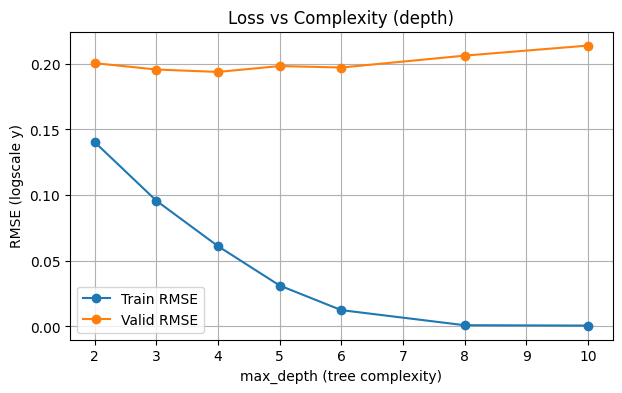

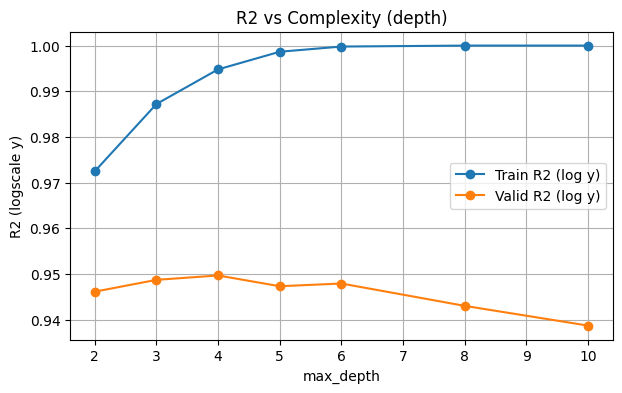

In [34]:
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

depths = [2,3,4,5,6,8,10]
train_losses, valid_losses = [], []
train_r2, valid_r2 = [], []

for d in depths:
    m = XGBRegressor(
        n_estimators=3000,
        learning_rate=0.05,
        max_depth=d,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42
    )
    m.fit(
        X_train, ylog_train,
        eval_set=[(X_train, ylog_train), (X_test, ylog_test)],
        eval_metric="rmse",
        early_stopping_rounds=50,
        verbose=False
    )
    it = m.best_iteration
    ev = m.evals_result_
    train_losses.append(ev['validation_0']['rmse'][it])
    valid_losses.append(ev['validation_1']['rmse'][it])

    # R2 scores over ylog
    train_r2.append(r2_score(ylog_train, m.predict(X_train)))
    valid_r2.append(r2_score(ylog_test,  m.predict(X_test)))

plt.figure(figsize=(7,4))
plt.plot(depths, train_losses, '-o', label='Train RMSE')
plt.plot(depths, valid_losses, '-o', label='Valid RMSE')
plt.xlabel('max_depth (tree complexity)')
plt.ylabel('RMSE (logscale y)')
plt.title('Loss vs Complexity (depth)')
plt.legend(); plt.grid(True); plt.show()

# Same graph but with R2 to compare with previous plots
plt.figure(figsize=(7,4))
plt.plot(depths, train_r2, '-o', label='Train R2 (log y)')
plt.plot(depths, valid_r2, '-o', label='Valid R2 (log y)')
plt.xlabel('max_depth')
plt.ylabel('R2 (logscale y)')
plt.title('R2 vs Complexity (depth)')
plt.legend(); plt.grid(True); plt.show()


In the graph, we can see that, as the tree depth (max_depth) increases, the training loss (RMSE train) continuously decreases, while the validation loss (RMSE valid) reaches its minimum around max_depth = 4 and then slightly worsens.
This indicates that, beyond a medium complexity, the model starts to overfit (it learns noise from the training data).
The increasing gap between both curves (train decreases → valid stable or increasing) reflects this generalization gap.
Therefore, the model is not overfitted if a moderate depth (≈ 4 – 5) is chosen where validation is minimal and stable.
In that area, the test performance is maximum and the balance between bias and variance is adequate.


---
Ex 2. Obtain and plot variable importance measures using the following variable groups

In [35]:
variable_groups = {
    'age': ['age'],
    'body': ['height_cm', 'weight_kg'],
    'attacking': ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys'],
    'skill': ['skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control'],
    'movement': ['movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance'],
    'power': ['power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots'],
    'mentality': ['mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties',
        'mentality_composure'],
    'defending': ['defending_marking', 'defending_standing_tackle','defending_sliding_tackle'],
    'goalkeeping' : ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']
}

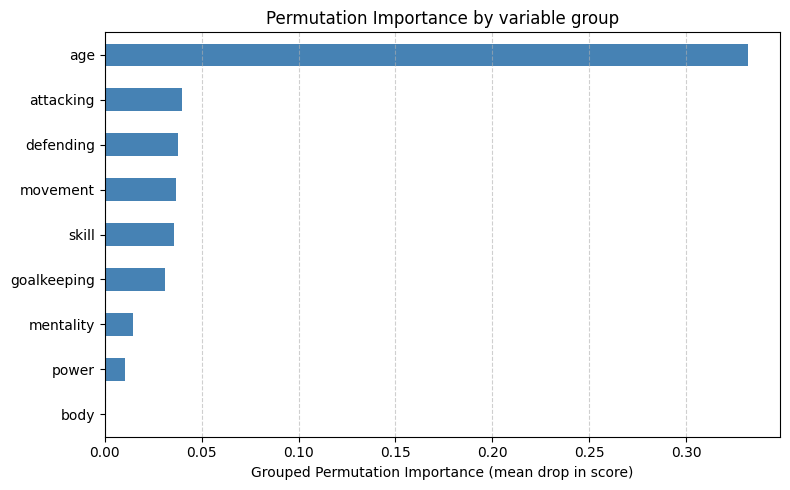

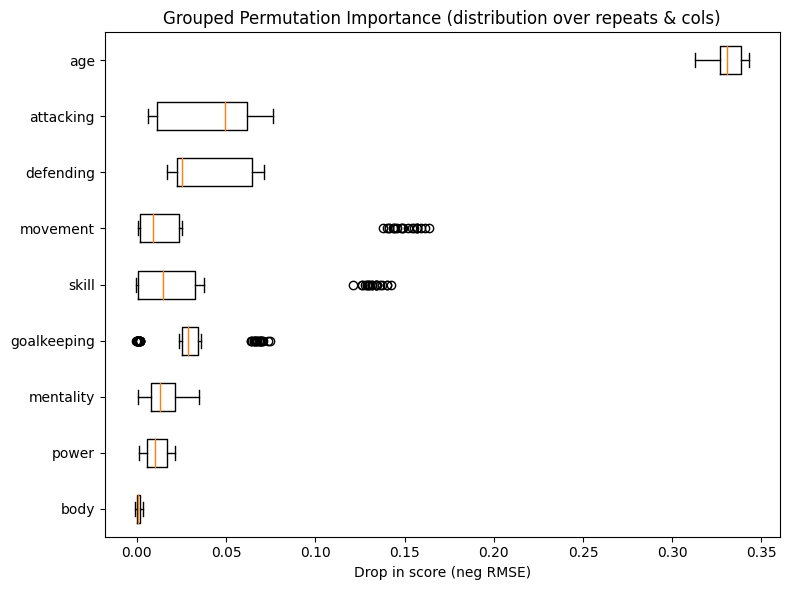

In [38]:
from sklearn.metrics import make_scorer, mean_squared_error

# The model was trained on log(y), so we evaluate on ylog_test
# and use a "the higher the better" metric (neg_root_mean_squared_error)
def neg_rmse(y_true, y_pred):
    return -mean_squared_error(y_true, y_pred, squared=False)

scorer = make_scorer(neg_rmse, greater_is_better=True)

# 1) Permutation importance per FEATURE
perm = permutation_importance(
    model, X_test, ylog_test,
    n_repeats=20, random_state=0, scoring=scorer
)

# DataFrame with means and distributions per column
feat_order = perm.importances_mean.argsort()[::-1]
imp_df = pd.DataFrame({
    "feature": X_test.columns,
    "mean": perm.importances_mean,
    "std": perm.importances_std
}).set_index("feature").iloc[feat_order]

# 2) Group aggregation (mean importance of group columns)
#    Note: we aggregate means (and also gather samples for boxplot per group).
group_means = {}
group_samples = {}

for g, cols in variable_groups.items():
    cols_in_X = [c for c in cols if c in X_test.columns]
    if not cols_in_X:
        continue
    # mean of the means for the group's columns
    group_means[g] = imp_df.loc[cols_in_X, "mean"].mean()

    # concatenate all repetitions of all columns in the group
    idxs = [X_test.columns.get_loc(c) for c in cols_in_X]
    samples = np.concatenate([perm.importances[i] for i in idxs], axis=0)
    group_samples[g] = samples

group_imp_series = pd.Series(group_means).sort_values(ascending=False)

# 3) Plot BAR (groups) — same style as the barh from permutation_importance in the notebook
plt.figure(figsize=(8,5))
group_imp_series.plot(kind="barh", color="steelblue")
plt.gca().invert_yaxis()
plt.xlabel("Grouped Permutation Importance (mean drop in score)")
plt.title("Permutation Importance by variable group")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 4) Plot BOX (groups) — aggregating all samples from the group's columns
labels = list(group_imp_series.index)[::-1]
data_box = [group_samples[g] for g in labels]

plt.figure(figsize=(8,6))
plt.boxplot(data_box, vert=False, labels=labels)
plt.title("Grouped Permutation Importance (distribution over repeats & cols)")
plt.xlabel("Drop in score (neg RMSE)")
plt.tight_layout()
plt.show()


I used **Permutation Feature Importance** because it directly measures how much each variable (or group of variables) contributes to the model’s predictive performance.
By randomly shuffling the values of a feature and observing the drop in model accuracy (or increase in error), we can see how dependent the model is on that feature.
This method is **model-agnostic**, meaning it works with any model—including our XGBoost regressor—and provides an intuitive, quantitative measure of importance.
Unlike built-in tree importances, permutation importance reflects the **true impact on predictions** rather than how often a variable is used in splits.

---
Ex 3. Obtain which is the variable with higher influence in Leo Messi's value. Justify which algorithm you choose

[Ex3] Selected row for Messi: index=0, short_name=L. Messi


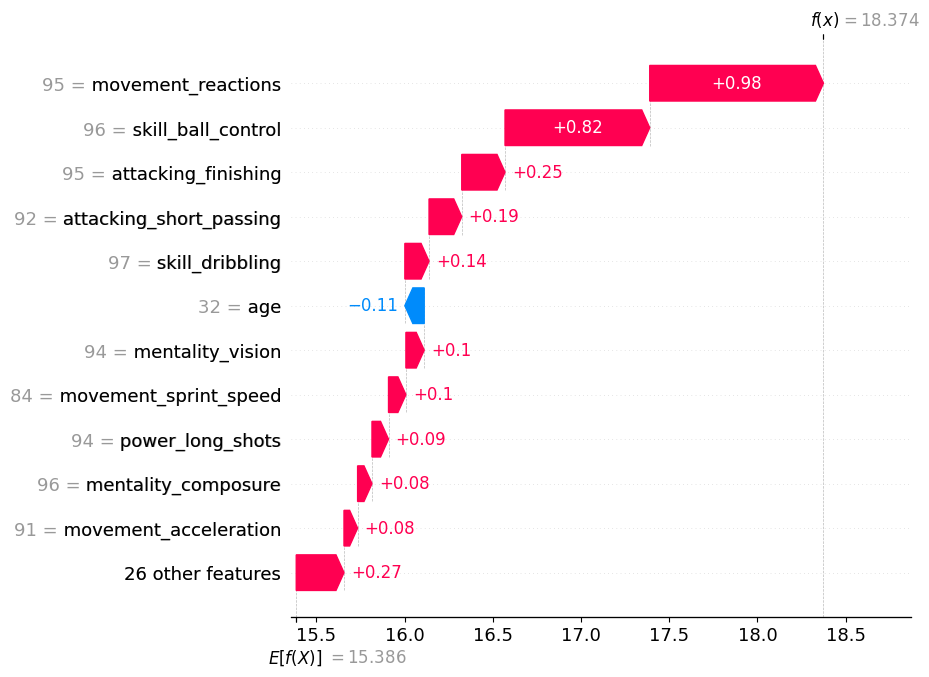

In [37]:
# 1) Locate Messi row by short_name (as shown in the dataset preview: "L. Messi")
if "short_name" not in df.columns:
    raise ValueError("Column 'short_name' not found in df.")

messi_rows = df[df["short_name"].astype(str).str.fullmatch(r"L\.?\s*Messi", case=False, na=False)]
if messi_rows.empty:
    messi_rows = df[df["short_name"].astype(str).str.contains("messi", case=False, na=False)]
    if messi_rows.empty:
        raise ValueError("Could not find Messi in 'short_name' column.")

# Prefer the one with the highest value_eur if multiple rows exist
if "value_eur" in messi_rows.columns and len(messi_rows) > 1:
    messi_row = messi_rows.sort_values("value_eur", ascending=False).iloc[0]
else:
    messi_row = messi_rows.iloc[0]

messi_idx = messi_row.name
print(f"[Ex3] Selected row for Messi: index={messi_idx}, short_name={messi_row['short_name']}")

# 2) Build the feature vector with the same columns used to train
assert set(X_train.columns) == set(X_test.columns), "Train/Test columns mismatch."

if messi_idx in X_test.index:
    x_messi = X_test.loc[[messi_idx]].copy()
elif messi_idx in X_train.index:
    x_messi = X_train.loc[[messi_idx]].copy()
else:
    x_messi = df.loc[[messi_idx], X_train.columns].copy()

# 3) SHAP local explanation for XGBRegressor trained on log(target)
bg = X_train.sample(min(200, len(X_train)), random_state=42) if len(X_train) > 0 else X_test.sample(min(200, len(X_test)), random_state=42)

explainer = shap.TreeExplainer(model, data=bg, feature_perturbation="interventional")
shap_values = explainer.shap_values(x_messi)
base_value = explainer.expected_value

# 4) Waterfall plot (single visualization)
ex = shap.Explanation(
    values=shap_values[0],
    base_values=base_value,
    data=x_messi.values[0],
    feature_names=list(x_messi.columns)
)

shap.plots.waterfall(ex, max_display=12)


>>>I used **SHAP (SHapley Additive Explanations)** because it’s the most reliable way to understand how each feature influences a single prediction.
Since our model is based on trees (XGBoost), SHAP works efficiently and gives consistent local explanations that sum up exactly to the final prediction.
In Messi’s case, the feature with the biggest positive SHAP value is **movement_reactions**, meaning that his extremely high reaction score contributes the most to increasing his market value.
Other skills like ball control and finishing also add positively, while age slightly decreases it, which makes sense because older players usually lose value.
Overall, SHAP clearly shows that Messi’s quick reactions are the main driver of his high estimated value in the model.


---
Ex 4. Explain how perturbating the `height_cm` variable affect the value of Cristiano Ronaldo

[Ex4] Selected row for Cristiano: index=1, short_name=Cristiano Ronaldo
[Ex4] Cristiano height_cm = 187.0 cm
[Ex4] Predicted value at actual height ≈ €59,688,716
[Ex4] Local sensitivity ≈ €336,264 per cm (around current height)


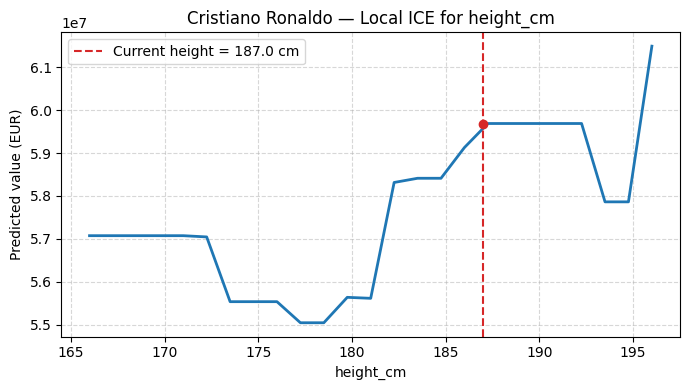

In [42]:
# --- Ex 4: Local ICE for Cristiano Ronaldo on 'height_cm' ---

# 1) Localize Cristiano Ronaldo row by short_name
if "short_name" not in df.columns:
    raise ValueError("Column 'short_name' not found in df.")

cr_rows = df[
    df["short_name"].astype(str).str.fullmatch(r"(C\.?\s*Ronaldo|Cristiano Ronaldo)", case=False, na=False)
]
if cr_rows.empty:
    cr_rows = df[df["short_name"].astype(str).str.contains("ronaldo", case=False, na=False)]
    # If there are multiple Ronaldos, try to filter by highest value_eur
    if "value_eur" in cr_rows.columns and len(cr_rows) > 1:
        cr_rows = cr_rows.sort_values("value_eur", ascending=False).head(1)

if cr_rows.empty:
    raise ValueError("Could not find Cristiano Ronaldo in 'short_name' column.")

cr_row = cr_rows.iloc[0]
cr_idx = cr_row.name
print(f"[Ex4] Selected row for Cristiano: index={cr_idx}, short_name={cr_row['short_name']}")

# 2) Retrieve feature vector with same columns as training
assert set(X_train.columns) == set(X_test.columns), "Train/Test columns mismatch."
if cr_idx in X_test.index:
    x_cr = X_test.loc[[cr_idx]].copy()
elif cr_idx in X_train.index:
    x_cr = X_train.loc[[cr_idx]].copy()
else:
    x_cr = df.loc[[cr_idx], X_train.columns].copy()

# 3) Build a plausible grid of heights (percentiles of the dataset to avoid extrapolation)
h_min = float(X["height_cm"].quantile(0.01))
h_max = float(X["height_cm"].quantile(0.99))
grid = np.linspace(h_min, h_max, 25)

# 4) Base prediction (in euros) with the actual height
y_cr_base_eur = float(predict_function(model, x_cr))  # remember: predict_function = exp(model.predict)

# 5) Local ICE curve: vary only 'height_cm' in Cristiano's row
y_ice_eur = []
for h in grid:
    x_tmp = x_cr.copy()
    x_tmp.loc[:, "height_cm"] = h
    y_ice_eur.append(float(predict_function(model, x_tmp)))

y_ice_eur = np.array(y_ice_eur)

# 6) Local slope (approximate sensitivity) at current height
h0 = float(df.loc[cr_idx, "height_cm"])
# finite differences approximation on the interpolated curve
y_interp = np.interp([h0 - 0.5, h0 + 0.5], grid, y_ice_eur)  # +/- 0.5 cm
local_slope_eur_per_cm = (y_interp[1] - y_interp[0]) / 1.0

print(f"[Ex4] Cristiano height_cm = {h0:.1f} cm")
print(f"[Ex4] Predicted value at actual height ≈ €{y_cr_base_eur:,.0f}")
print(f"[Ex4] Local sensitivity ≈ €{local_slope_eur_per_cm:,.0f} per cm (around current height)")

# 7) Plot ICE curve
plt.figure(figsize=(7,4))
plt.plot(grid, y_ice_eur, lw=2)
plt.axvline(h0, color="tab:red", linestyle="--", label=f"Current height = {h0:.1f} cm")
plt.scatter([h0], [y_cr_base_eur], color="tab:red", zorder=3)
plt.title("Cristiano Ronaldo — Local ICE for height_cm")
plt.xlabel("height_cm")
plt.ylabel("Predicted value (EUR)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


>>> In the ICE plot, we can see how Cristiano Ronaldo’s predicted market value changes when we modify only his `height_cm` while keeping all other attributes fixed.
Around his actual height of **187 cm**, the curve is slightly increasing, meaning that the model predicts a small rise in value for taller players.
The local sensitivity (≈ €336 k per cm) confirms that height has a **positive but moderate effect** on his valuation.
This suggests that, although height contributes somewhat—probably due to its correlation with power or heading ability—it is far less important than technical or movement skills such as finishing, reactions, or acceleration.
Overall, perturbing `height_cm` shows that **Ronaldo’s value is mostly stable with respect to height**, and small variations in centimeters do not drastically change his predicted market value.


---
Ex 5. Explain the average effect of the `age` variable on the model predictions. Does it differ greatly along the samples in the dataset? Which should be more affected by perturbating this variable, the goalkeepers or the strikers?

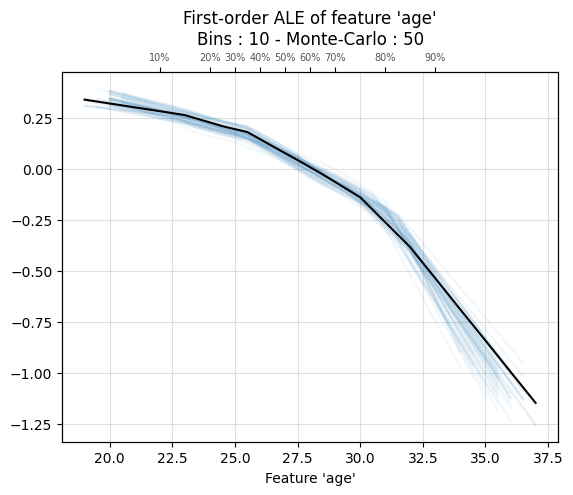

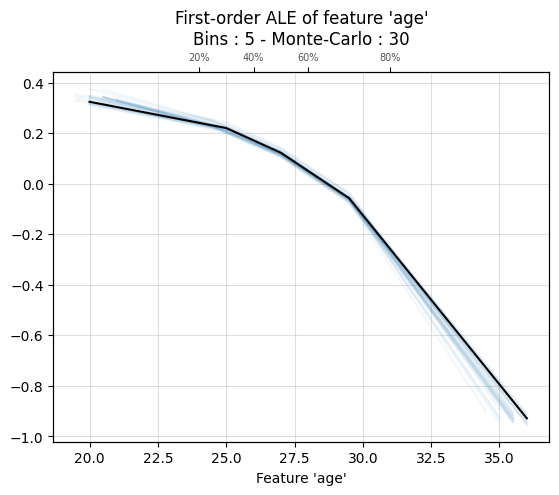

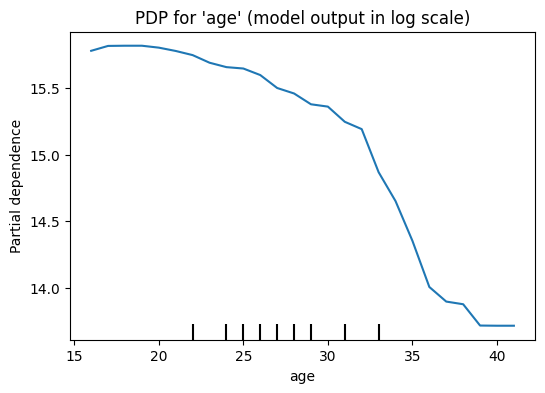

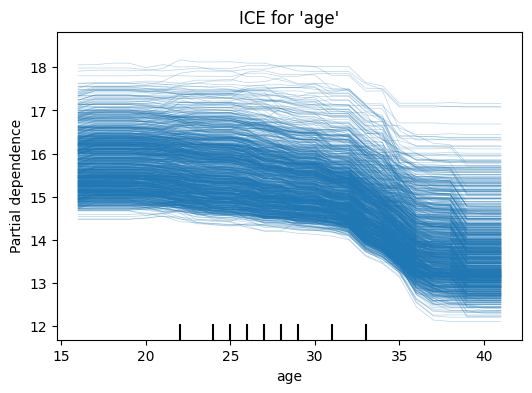

In [47]:
# Wrapper to ensure we always get (fig, ax) from ale_plot
def ale_plot_safe(*args, **kwargs):
    out = ale_plot(*args, **kwargs)
    if isinstance(out, tuple):           # versions that return (fig, ax)
        fig, ax = out
    else:                                 # versions that return only Axes
        ax = out
        fig = ax.get_figure()
    return fig, ax

# 1) ALE main effect for 'age' with Monte Carlo sampling
fig, ax = ale_plot_safe(model, X_train, "age", monte_carlo=True)
fig.suptitle("ALE of 'age' (main effect)", y=1.02)
fig.tight_layout()
plt.show()

# 2) ALE with 5 bins and Monte Carlo sampling
fig, ax = ale_plot_safe(
    model,
    X_train,
    "age",
    bins=5,
    monte_carlo=True,
    monte_carlo_rep=30,
    monte_carlo_ratio=0.5,
)
fig.suptitle("ALE of 'age' (bins=5, MC ratio=0.5, reps=30)", y=1.02)
fig.tight_layout()
plt.show()


# PDP and ICE for 'age'
fig, ax = plt.subplots(figsize=(6,4))
PartialDependenceDisplay.from_estimator(model, X_train, features=["age"], kind="average", ax=ax)
ax.set_title("PDP for 'age' (model output in log scale)")
plt.show()

fig, ax = plt.subplots(figsize=(6,4))
PartialDependenceDisplay.from_estimator(model, X_train, features=["age"], kind="individual", ax=ax)
ax.set_title("ICE for 'age'")
plt.show()


>>> The ALE and PDP plots show a clear negative relationship between age and the predicted market value.
Up to around 25–27 years, the effect is almost flat, meaning the model doesn’t penalize young players much. After that, the curve drops sharply, indicating that older players are predicted to have lower values.
The ICE plot confirms this trend for almost all players, the lines follow a similar downward pattern, showing that the effect of age is consistent across the dataset, with only small individual differences.
Regarding positions, strikers are more affected by changes in age because their performance relies heavily on physical attributes like speed and reactions, which decline faster with age.
Goalkeepers, on the other hand, tend to lose value more slowly, since their effectiveness depends more on positioning and experience.

---
Ex 6. Explain the prediction made for Hazard using a local surrogate model (Lime)

[Ex6] Selected row for Hazard: index=4, short_name=E. Hazard


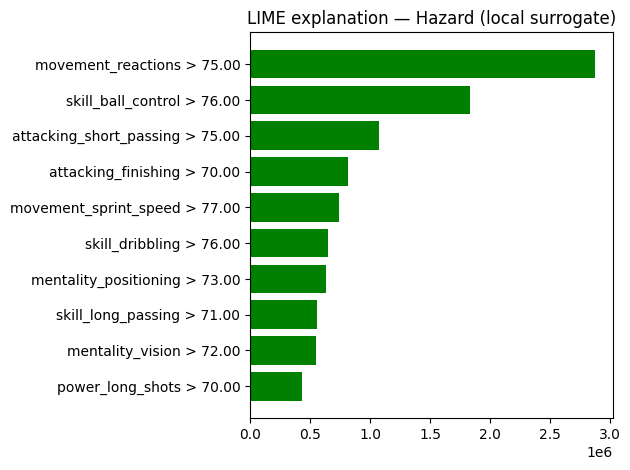


[Ex6] Top contributions (feature, weight):
  movement_reactions > 75.00                    +2878316.061
  skill_ball_control > 76.00                    +1830073.958
  attacking_short_passing > 75.00               +1071190.672
  attacking_finishing > 70.00                   +815645.912
  movement_sprint_speed > 77.00                 +743660.822
  skill_dribbling > 76.00                       +644360.573
  mentality_positioning > 73.00                 +629572.161
  skill_long_passing > 71.00                    +559536.418
  mentality_vision > 72.00                      +552552.146
  power_long_shots > 70.00                      +435205.724

[Ex6] Model prediction (EUR):   90,326,464
[Ex6] LIME local model (EUR):    12,438,298


In [54]:
import lime.lime_tabular

# 1) Find Hazard by short_name
if "short_name" not in df.columns:
    raise ValueError("Column 'short_name' not found in df.")

haz_rows = df[df["short_name"].astype(str).str.contains(r"\b(E\.?\s*Hazard|Eden Hazard)\b",
                                                        case=False, na=False)]
if haz_rows.empty:
    haz_rows = df[df["short_name"].astype(str).str.contains("hazard", case=False, na=False)]
if haz_rows.empty:
    raise ValueError("Could not find Hazard in 'short_name'.")

# If multiple rows, choose the one with highest value_eur
haz_row = (haz_rows.sort_values("value_eur", ascending=False).iloc[0]
           if "value_eur" in haz_rows.columns else haz_rows.iloc[0])
haz_idx = haz_row.name
print(f"[Ex6] Selected row for Hazard: index={haz_idx}, short_name={haz_row['short_name']}")

# 2) Retrieve feature vector with same columns as training
assert set(X_train.columns) == set(X_test.columns), "Train/Test columns mismatch."
if haz_idx in X_test.index:
    x_haz = X_test.loc[[haz_idx]].copy()
elif haz_idx in X_train.index:
    x_haz = X_train.loc[[haz_idx]].copy()
else:
    x_haz = df.loc[[haz_idx], X_train.columns].copy()

# 3) Define prediction function that returns euros
def predict_eur(A):
    A_df = pd.DataFrame(A, columns=X_train.columns)
    return np.exp(model.predict(A_df))  # back to euros

# Fix random seed for reproducibility
np.random.seed(42)

# 4) Initialize LIME explainer (regression mode)
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=list(X_train.columns),
    mode="regression",
    discretize_continuous=True,
    sample_around_instance=True
)

# 5) Explain Hazard instance
np.random.seed(42)  # fix again before sampling perturbations
exp = explainer.explain_instance(
    data_row=x_haz.values[0],
    predict_fn=predict_eur,
    num_features=10
)

# 6) Plot result
fig = exp.as_pyplot_figure()
plt.title("LIME explanation — Hazard (local surrogate)")
plt.tight_layout()
plt.show()

# 7) Print top contributions
print("\n[Ex6] Top contributions (feature, weight):")
for f,w in exp.as_list():
    print(f"  {f:45s} {w:+.3f}")

# 8) Compare model prediction vs LIME local model
pred_true = float(predict_eur(x_haz.values)[0])
pred_lime = float(exp.predict_proba[0]) if hasattr(exp, "predict_proba") else float(exp.local_pred)
print(f"\n[Ex6] Model prediction (EUR):   {pred_true:,.0f}")
print(f"[Ex6] LIME local model (EUR):    {pred_lime:,.0f}")


>>> Using **LIME**, we built a simple local linear model around Hazard’s data to see which features most strongly influenced his predicted market value.
The explanation shows that **movement_reactions** and **ball control** have the highest positive impact, followed by **short passing**, **finishing**, and **sprint speed**, all of which contribute to increasing his predicted value.
These features represent Hazard’s strong **technical and movement abilities**, which are crucial for an attacking player.
Unlike before, there are no notable negative contributions — almost all relevant attributes push his value upward.
Overall, this LIME explanation confirms that Hazard’s market value in the model is primarily driven by his **attacking and technical performance**, rather than physical or defensive factors.
